<a href="https://colab.research.google.com/github/fukuda-kota/Harmony-Generate/blob/main/%E3%83%8F%E3%83%A2%E3%83%AA%E5%8F%96%E5%BE%97_ipynb%E3%80%80%E6%AD%A3%E8%A6%8F_%E3%80%802024_12_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 #  全体説明

1.   ライブラリ
2.   音源分離
3.   副旋律(ハモリ)生成
4.   音源合成



# ライブラリ

In [1]:
#ライブラリのインストールと準備

!pip install git+https://github.com/deezer/spleeter
!pip install librosa
!pip install pyworld
!pip install pydub
!pip install numpy
!pip install matplotlib
!pip install resampy
!pip install hmmlearn
!pip install essentia


  Cloning https://github.com/deezer/spleeter to /tmp/pip-req-build-ylr50xf0
  Running command git clone --filter=blob:none --quiet https://github.com/deezer/spleeter /tmp/pip-req-build-ylr50xf0
  Resolved https://github.com/deezer/spleeter to commit 9830c9b3dfbae3c677c0314b69522b4531748620
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 音源分離

 **input_file** に音源分離したいファイルのパスを入れると、

 **wav_files**に 主旋律と伴奏の分離された音源が格納される。


In [2]:
from spleeter.separator import Separator

input_file = '/content/ドライフラワー_1番のみ.wav'  # 入力ファイルのパス

# ボーカル抽出
def extract_vocals(input_file, output_file):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(input_file, output_file, codec='wav')

vocal_file = 'wav_files'
extract_vocals(input_file, vocal_file)

INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Validating archive checksum


INFO:spleeter:Validating archive checksum


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:2stems model file(s) extracted


INFO:spleeter:2stems model file(s) extracted
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


INFO:spleeter:File wav_files/ドライフラワー_1番のみ/vocals.wav written succesfully


INFO:spleeter:File wav_files/ドライフラワー_1番のみ/vocals.wav written succesfully


INFO:spleeter:File wav_files/ドライフラワー_1番のみ/accompaniment.wav written succesfully


INFO:spleeter:File wav_files/ドライフラワー_1番のみ/accompaniment.wav written succesfully


## 副旋律（ハモリ）生成

**vocal_wav_path**に主旋律（ボーカル）のみの音源のパスを、

**accompaniment_wav_path**に伴奏のみの音源のパスを入力すると、ハモリ音源が生成できる。


Vocal track length: 10834061, Accompaniment track length: 10834061
Extracted 45142 pitch values.
Chromagram smoothing: original shape (12, 45142), smoothed shape (12, 45142)


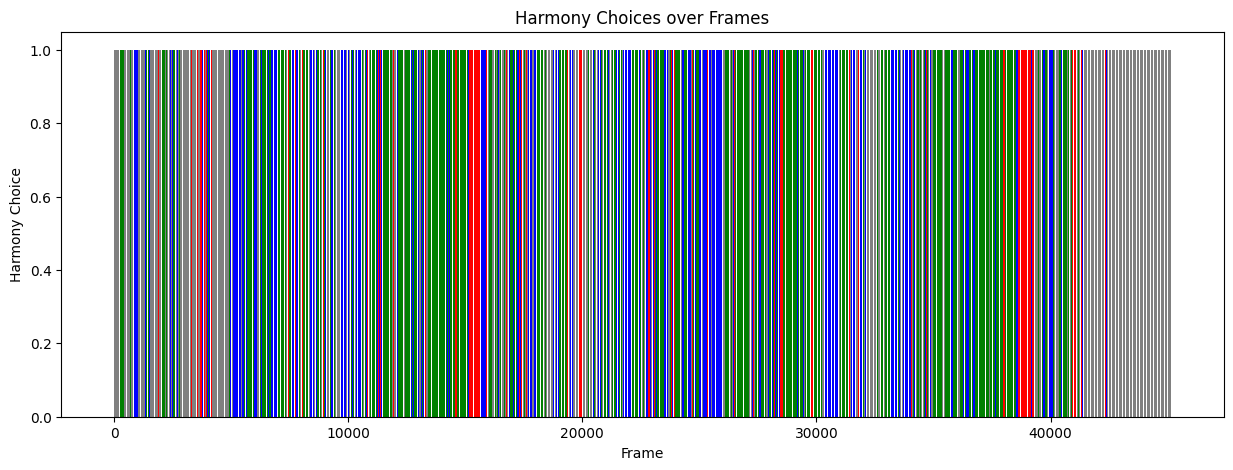

In [ ]:
import librosa
import numpy as np
import pyworld as pw
import soundfile as sf
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# ボーカルトラックと伴奏トラックを読み込み、処理する関数
def load_and_process_tracks(vocal_path, accompaniment_path, sr=48000):
    try:
        y_vocal, _ = librosa.load(vocal_path, sr=sr, dtype='float64')
        y_accompaniment, _ = librosa.load(accompaniment_path, sr=sr, dtype='float64')
    except Exception as e:
        print(f"Error loading tracks: {e}")
        return None, None

    # トラックの長さをチェック
    print(f"Vocal track length: {len(y_vocal)}, Accompaniment track length: {len(y_accompaniment)}")

    chroma = librosa.feature.chroma_stft(y=y_accompaniment, sr=sr, hop_length=int(sr*0.005))
    return y_vocal, chroma


# pyworldを使ってピッチを抽出する関数
def extract_pitch(y, sr):
    try:
        f0, t = pw.dio(y, sr)
        f0 = pw.stonemask(y, f0, t, sr)
    except Exception as e:
        print(f"Error in pitch extraction: {e}")
        return None, None

    # ピッチ抽出結果の確認
    print(f"Extracted {len(f0)} pitch values.")
    return f0, t


# クロマグラムを平滑化する関数
def smooth_chromagram(chromagram, window_size=200):
    smoothed = uniform_filter1d(chromagram, size=window_size, axis=1)
    # 平滑化前後の変化を表示
    print(f"Chromagram smoothing: original shape {chromagram.shape}, smoothed shape {smoothed.shape}")
    return smoothed


# 状態遷移確率行列と出力確率を定義
transition_probabilities_same_pitch = {
    "major_third": {"major_third": 0.7, "minor_third":0.15, "perfect_fourth": 0.1, "none": 0.05},
    "minor_third": {"major_third": 0.15, "minor_third": 0.7, "perfect_fourth": 0.1, "none": 0.05},
    "perfect_fourth": {"major_third": 0.2, "minor_third": 0.2, "perfect_fourth": 0.6, "none": 0.1},
    "none": {"major_third": 0.35, "minor_third": 0.35, "perfect_fourth": 0.25, "none": 0.05}
}

transition_probabilities_different_pitch = {
    "major_third": {"major_third": 0.35, "minor_third": 0.35, "perfect_fourth": 0.25, "none": 0.05},
    "minor_third": {"major_third": 0.35, "minor_third": 0.35, "perfect_fourth": 0.25, "none": 0.05},
    "perfect_fourth": {"major_third": 0.35, "minor_third": 0.35, "perfect_fourth": 0.25, "none": 0.05},
    "none": {"major_third": 0.3, "minor_third": 0.3, "perfect_fourth": 0.3, "none": 0.1}
}

output_probabilities = {
    "major_third": None,
    "minor_third": None,
    "perfect_fourth": None,
    "none": None
}

# 時間軸方向の音階ごとの平均値を計算
def calculate_chroma_mean(chromagram):
    return np.mean(chromagram, axis=1)

# 音階の時間平均確率を基に選択確率を計算
def calculate_mean_probability(note_index, chroma_mean):
    return chroma_mean[note_index]

# クロマグラムから出力確率を計算する関数
def calculate_output_probabilities(chroma_frame, epsilon=0.0001):
    total = np.sum(chroma_frame)
    smoothed_chroma_frame = chroma_frame + epsilon  # 微小値を足してスムージング
    if total == 0:
        return smoothed_chroma_frame / np.sum(smoothed_chroma_frame)  # 再正規化
    return smoothed_chroma_frame / (total + epsilon * len(chroma_frame))  # 再正規化

# 半音でぶつかっている確率を計算する関数
def calculate_collision_probability(chroma_prob, note_index):
    half_step_up = (note_index + 1) % 12
    half_step_down = (note_index - 1) % 12
    collision_prob = 1 - (chroma_prob[half_step_up] + chroma_prob[half_step_down])
    return max(0, collision_prob)

# ハモリ音を選択する関数
def choose_harmony_note_viterbi(original_pitch, harmony_candidates, chroma_frame, prev_state,
                                transition_probabilities, harmony_direction, weights, chroma_mean):
    if original_pitch == 0:
        return 0, "none"

    # クロマフレームから出力確率を計算
    chroma_prob = calculate_output_probabilities(chroma_frame)

    max_prob = 0
    selected_harmony_pitch = None
    selected_state = None

    for state in harmony_candidates:
        if state == "none":
            candidate_pitch = 0
        elif state == "major_third":
            candidate_pitch = original_pitch * (2 ** (-4 / 12))
        elif state == "minor_third":
            candidate_pitch = original_pitch * (2 ** (-3 / 12))
        elif state == "perfect_fourth":
            candidate_pitch = original_pitch * (2 ** (-5 / 12))

        if candidate_pitch <= 0:
            continue

        # 遷移確率と出力確率を組み合わせて最大確率の状態を選択
        if prev_state in transition_probabilities:
            note_index = int(np.round(np.log2(candidate_pitch / 440) * 12) + 9) % 12
            transition_prob = transition_probabilities[prev_state][state]
            output_prob = chroma_prob[note_index]
            collision_prob = calculate_collision_probability(chroma_prob, note_index)
            mean_prob = calculate_mean_probability(note_index, chroma_mean)

            # 重み付けを適用して確率の積を計算
            prob = (
                (transition_prob ** weights["transition"])
                * (output_prob ** weights["output"])
                * (collision_prob ** weights["collision"])
                * (mean_prob ** weights["mean"])
            )

            if prob > max_prob:
                max_prob = prob
                selected_harmony_pitch = candidate_pitch
                selected_state = state
        else:
            selected_harmony_pitch = candidate_pitch
            selected_state = state

    if selected_harmony_pitch is None:
        return 0, "none"

    return selected_harmony_pitch, selected_state

# ハーモニーを生成する関数（重みを指定可能に変更）
def generate_harmony(y_vocal, sr, chromagram, output_file, harmony_direction="down", weights=None):
    f0, t = extract_pitch(y_vocal, sr)
    sp = pw.cheaptrick(y_vocal, f0, t, sr)
    ap = pw.d4c(y_vocal, f0, t, sr)
    smoothed_chromagram = smooth_chromagram(chromagram)

    # 時間軸方向の平均値を計算
    chroma_mean = calculate_chroma_mean(smoothed_chromagram)

    harmony_pitch = np.copy(f0)
    harmony_choices = []

    prev_state = "none"

    for i in range(len(f0)):
        if f0[i] == 0:
            harmony_pitch[i] = 0
            harmony_choices.append("none")
            continue

        harmony_candidates = ["major_third", "minor_third", "perfect_fourth", "none"]

        # ピッチが前の音と同じかどうかを比を用いて判断
        if i > 0 and f0[i - 1] != 0 and (f0[i] / f0[i - 1] > 0.99 and f0[i] / f0[i - 1] < 1.01):
            selected_note, prev_state = choose_harmony_note_viterbi(
                f0[i], harmony_candidates, smoothed_chromagram[:, i], prev_state,
                transition_probabilities_same_pitch, harmony_direction, weights, chroma_mean
            )
        else:
            selected_note, prev_state = choose_harmony_note_viterbi(
                f0[i], harmony_candidates, smoothed_chromagram[:, i], prev_state,
                transition_probabilities_different_pitch, harmony_direction, weights, chroma_mean
            )

        harmony_choices.append(prev_state)
        harmony_pitch[i] = selected_note

    harmonic = pw.synthesize(harmony_pitch, sp, ap, sr)
    sf.write(output_file, harmonic, sr)

    return harmony_choices

def plot_harmony_choices(harmony_choices):
    fig, ax = plt.subplots(figsize=(15, 5))
    colors = {"major_third": "blue", "minor_third": "green", "perfect_fourth": "red", "none": "gray"}
    for i, choice in enumerate(harmony_choices):
        ax.bar(i, 1, color=colors[choice])

    ax.set_xlabel("Frame")
    ax.set_ylabel("Harmony Choice")
    ax.set_title("Harmony Choices over Frames")
    plt.show()

# メイン処理で重みを指定
vocal_wav_path = '/content/津軽海峡冬景色_vocals.wav'
accompaniment_wav_path = '/content/津軽海峡冬景色_accompaniment.wav'

weights = {"transition": 1, "output": 1, "collision": 0.75, "mean": 0.75}  # 重みを一箇所で管理

y_vocal, chromagram_accompaniment = load_and_process_tracks(vocal_wav_path, accompaniment_wav_path)
harmony_choices = generate_harmony(y_vocal, 48000, chromagram_accompaniment, 'harmony_津軽海峡冬景色.wav', harmony_direction='down', weights=weights)


#plot_harmony_choices(harmony_choices)




## 音源合成

前のパートで生成したハモリ音源などを合成して一つの音源にできる。

右の音量調節部分を活用することで、様々なパターンの音源を作成してみよう。

例：伴奏の音量を-20にする → ハモリ＋主旋律のみの音源が作れる

In [ ]:
from pydub import AudioSegment

# 主旋律のみ音源を読み込む
vocal = AudioSegment.from_file("/content/harmony_KING_1番のみ_b.wav")

# 伴奏のみ音源を読み込む
accompaniment = AudioSegment.from_file("/content/KING_1番のみ.wav")

# 副旋律（ハモリ音源）を読み込む
harmony = AudioSegment.from_file("/content/another_harmony_KING.wav")

# 主旋律の音量を調整する
vocal = 6 #@param {type:"slider", min:-20.0, max:20.0, step:1.0}


# 伴奏の音量を調整する（そのまま）
accompaniment = -20 #@param {type:"slider", min:-20.0, max:20.0, step:1.0}

# 副旋律（ハモリ音源）の音量を調整する（適宜調整）
harmony = -20 #@param {type:"slider", min:-20.0, max:20.0, step:1.0}

# 音源を合成する
combined = vocal.overlay(accompaniment).overlay(harmony)

# 合成した音源を保存する
combined.export("combined_KING_１番のみ_b.wav", format="wav")